# Imports and configuring a reproducibility seed

In [1]:
import os

import numpy as np
import random
import tensorflow as tf

seed = 1729959202

np.random.seed(seed)

random.seed(seed)

tf.random.set_seed(seed)

import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, roc_curve, auc
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam


from tensorflow.keras.mixed_precision import set_global_policy
set_global_policy('mixed_float16')


2024-11-23 16:48:55.991976: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732376936.112742     872 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732376936.144441     872 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-23 16:48:56.458058: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Read data from I/O

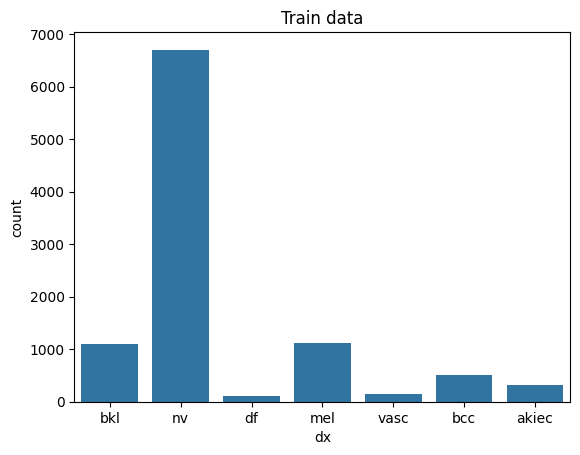

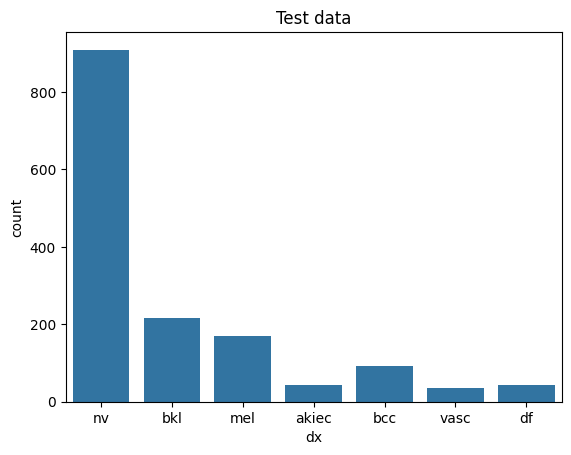

In [2]:
data_path = 'data/ham10000/HAM10000_metadata.csv'
df = pd.read_csv(data_path)

image_dir = 'data/ham10000/images/'  
test_image_dir = 'data/ham10000/images/test_images/'

df['image_path'] = image_dir + df['image_id'] + '.jpg'

df.head()

label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['dx'])

sns.countplot(x='dx', data=df)
plt.title('Train data')
plt.show()

test_data_path = 'data/ham10000/images/ISIC2018_Task3_Test_GroundTruth.csv'

test_df = pd.read_csv(test_data_path)
test_df['image_path'] = test_image_dir + test_df['image_id'] + '.jpg'
test_df['label'] = label_encoder.transform(test_df['dx'])

sns.countplot(x='dx', data=test_df)
plt.title('Test data')
plt.show()

train_df, val_df = train_test_split(df, test_size=0.1, stratify=df['label'], random_state=42)

# Check for data leaks

In [3]:
# Extract only the image name and extension for each set
train_set = set(os.path.basename(path) for path in train_df['image_path'])
val_set = set(os.path.basename(path) for path in val_df['image_path'])
test_set = set(os.path.basename(path) for path in test_df['image_path'])

# print the path of the first image in the training set and the test set
print("First image in the training set:", list(train_set)[0])
print("First image in the test set:", list(test_set)[0])



print("Overlaps between train and validation:", len(train_set.intersection(val_set)))
print("Overlaps between train and test:", len(train_set.intersection(test_set)))
print("Overlaps between validation and test:", len(val_set.intersection(test_set)))

First image in the training set: ISIC_0031853.jpg
First image in the test set: ISIC_0035406.jpg
Overlaps between train and validation: 0
Overlaps between train and test: 0
Overlaps between validation and test: 0


# Convert label to string for API compatibility

In [4]:
train_df['label'] = train_df['label'].astype(str)
val_df['label'] = val_df['label'].astype(str)
test_df['label'] = test_df['label'].astype(str)

# Load and Augment Images and create tf.Data.Dataset instances for all parts of the data

In [5]:
image_size = (128, 128)
batch_size = 64
num_classes = len(df['dx'].unique())
img_height, img_width = image_size

def load_and_preprocess_image(image_path, label, augment=False):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [img_height, img_width]) / 255.0  

    if augment:
        img = tf.image.rot90(img, k=tf.random.uniform([], 0, 4, dtype=tf.int32))  
        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_brightness(img, max_delta=0.2)

    return img, label

def create_dataset(df, augment=False, batch_size=32):
    df = df[df['image_path'].apply(os.path.exists)]
    
    image_paths = df['image_path'].values
    labels = df['label'].values
    labels = tf.keras.utils.to_categorical(labels, num_classes)

    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))

    def preprocess_with_augment(image_path, label):
        return load_and_preprocess_image(image_path, label, augment)

    dataset = dataset.map(preprocess_with_augment, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

    return dataset

train_dataset = create_dataset(train_df, augment=True, batch_size=batch_size).prefetch(buffer_size=1)
val_dataset = create_dataset(val_df, batch_size=batch_size).prefetch(buffer_size=1)


I0000 00:00:1732376940.528562     872 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5564 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:09:00.0, compute capability: 8.6


In [6]:
import autokeras as ak

# Define the AutoKeras ImageClassifier
clf = ak.ImageClassifier(
    overwrite=True,
    max_trials=50,  # You can adjust the number of trials
    objective='val_accuracy',
)

In [ ]:
clf.fit(train_dataset, epochs=20, validation_data=val_dataset)

Trial 1 Complete [00h 05m 17s]
val_accuracy: 0.7475050091743469

Best val_accuracy So Far: 0.7475050091743469
Total elapsed time: 00h 05m 17s

Search: Running Trial #2

Value             |Best Value So Far |Hyperparameter
resnet            |vanilla           |image_block_1/block_type
True              |True              |image_block_1/normalize
True              |False             |image_block_1/augment
True              |None              |image_block_1/image_augmentation_1/horizontal_flip
True              |None              |image_block_1/image_augmentation_1/vertical_flip
0                 |None              |image_block_1/image_augmentation_1/contrast_factor
0                 |None              |image_block_1/image_augmentation_1/rotation_factor
0.1               |None              |image_block_1/image_augmentation_1/translation_factor
0                 |None              |image_block_1/image_augmentation_1/zoom_factor
False             |None              |image_block_1/res_net_bl

2024-11-23 16:55:00.198785: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 16766464 bytes after encountering the first element of size 16766464 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-11-23 16:55:00.271653: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 16780800 bytes after encountering the first element of size 16780800 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-11-23 16:55:04.655359: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 272.00MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.

  1/141 ━━━━━━━━━━━━━━━━━━━━ 56:36 24s/step - accuracy: 0.0312 - loss: 3.5678Not enough memory, reduce batch size to 32.
Epoch 1/20


2024-11-23 16:55:18.118425: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:497] Allocator (GPU_0_bfc) ran out of memory trying to allocate 24.50MiB (rounded to 25690112)requested by op StatefulPartitionedCall/gradient_tape/functional_1/resnet50_1/conv5_block3_out_1/ReluGrad-0-TransposeNHWCToNCHW-LayoutOptimizer
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2024-11-23 16:55:18.118555: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1053] BFCAllocator dump for GPU_0_bfc
2024-11-23 16:55:18.118566: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1060] Bin (256): 	Total Chunks: 5936, Chunks in use: 5933. 1.45MiB allocated for chunks. 1.45MiB in use in bin. 48.7KiB client-requested in use in bin.
2024-11-23 16:55:18.118573: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1060] Bin (512): 	Total Chunks

    282/Unknown 94s 319ms/step - accuracy: 0.6377 - loss: 1.4090

2024-11-23 16:56:51.942449: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 18108506026968134755
/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-11-23 16:56:53.654483: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 12586496 bytes after encountering the first element of size 12586496 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-11-23 16:56:53.769657: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 16770048 bytes after encountering the first element of size 16770048 by

282/282 ━━━━━━━━━━━━━━━━━━━━ 100s 340ms/step - accuracy: 0.6378 - loss: 1.4083 - val_accuracy: 0.6218 - val_loss: 1.5129
Epoch 2/20


2024-11-23 16:56:58.149167: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 12586496 bytes after encountering the first element of size 12586496 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-11-23 16:56:58.261485: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 12586496 bytes after encountering the first element of size 12586496 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step - accuracy: 0.6635 - loss: 1.0291

2024-11-23 16:58:26.153255: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 16780800 bytes after encountering the first element of size 16780800 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-11-23 16:58:26.247503: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 12586496 bytes after encountering the first element of size 12586496 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-11-23 16:58:26.379406: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 16780800 bytes after encountering the first element of size 16780800 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

282/282 ━━━━━━━━━━━━━━━━━━━━ 91s 323ms/step - accuracy: 0.6635 - loss: 1.0291 - val_accuracy: 0.6687 - val_loss: 0.9482
Epoch 3/20


2024-11-23 16:58:29.569231: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 16780800 bytes after encountering the first element of size 16780800 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-11-23 16:58:29.721195: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 12593664 bytes after encountering the first element of size 12593664 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-11-23 16:58:29.844032: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 16770048 bytes after encountering the first element of size 16770048 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step - accuracy: 0.6634 - loss: 1.0482

2024-11-23 16:59:59.702944: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 16780800 bytes after encountering the first element of size 16780800 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-11-23 16:59:59.820093: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 12586496 bytes after encountering the first element of size 12586496 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-11-23 16:59:59.984078: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 12586496 bytes after encountering the first element of size 12586496 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budg

282/282 ━━━━━━━━━━━━━━━━━━━━ 93s 328ms/step - accuracy: 0.6634 - loss: 1.0481 - val_accuracy: 0.6287 - val_loss: 1.0110
Epoch 4/20


2024-11-23 17:00:02.310134: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-11-23 17:00:02.523541: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 16780800 bytes after encountering the first element of size 16780800 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-11-23 17:00:02.672792: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 12586496 bytes after encountering the first element of size 12586496 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-11-23 17:00:02.845615: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tri

224/282 ━━━━━━━━━━━━━━━━━━━━ 19s 340ms/step - accuracy: 0.6739 - loss: 0.9554

In [ ]:
# Evaluate the model
test_dataset = create_dataset(test_df, batch_size=batch_size)
results = clf.evaluate(test_dataset)
print("Test accuracy: ", results)

In [ ]:
# Export the best model
model = clf.export_model()
model.save("autokeras/best_model_50_trials.h5")